# ZFNet

Source: https://towardsdatascience.com/zfnet-an-explanation-of-paper-with-code-f1bd6752121d

In [1]:
model_name = 'ZFNet-pre-processing-hist-eq-dark-and-canny-non-empty-3'

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import imageio as iio
import os
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from PIL import Image
from numba import cuda  # https://stackoverflow.com/a/52354865/6476994
import keras
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import csv
import re
from datetime import datetime
import collections
from readInImages import readInImages
from readInAnnotations import readInAnnotations

In [3]:
# allows all images to be displayed at once (else only displays the last call to plt.imshow())
# https://stackoverflow.com/a/41210974
def displayImage(image, caption = None, colour = None) -> None:
    plt.figure()
    if(colour != None):
        plt.imshow(image, cmap=colour)
    else:
        plt.imshow(image)
        
    if(caption != None):
        # display caption below picture (https://stackoverflow.com/a/51486361)
        plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)

In [4]:
# free up GPU if it didn't after the last run
cuda.select_device(0)
cuda.close()

## Read in dataset

* first argument is the `using_batch_generator` flag
* second argument is `do_preprocessing`, which will perform image manipulations for the purposes of enhancing training performance
* all other arguments are the datasets - e.g., a folder ('20160724_July') with additional folders ('BB01', 'BB02', ..., 'BBXY'), each containing a set of images)

In [5]:
%run readInDataset.py true true 20160724_July 20160829_August

args: ['readInDataset.py', 'true', 'true', '20160724_July', '20160829_August']
using_batch_generator? True
doing pre-processing? True
dataset_names: ['20160724_July', '20160829_August']
reading in images and labels for dataset: 20160724_July
all_folders_for_curr_dataset: ['BB01', 'BB02', 'BB03', 'BB04', 'BB05', 'BB06', 'BB07', 'BB08', 'BB09', 'BB10', 'BB11', 'BB12', 'BB13', 'BB14', 'BB15', 'BB16', 'BB17', 'BB18', 'BB19', 'BB20', 'BB21', 'BB22', 'BB23', 'BB24', 'BB25', 'BB26', 'BB27', 'BB28', 'BB29', 'BB30', 'BB31', 'BB32', 'BB33', 'BB34', 'BB35', 'BB36']
reading in labels for subset: BB01
returning labelList of length: 285
reading in images for subset: BB01
all_image_filenames length: 285
done current subset
reading in labels for subset: BB02
returning labelList of length: 45
reading in images for subset: BB02
all_image_filenames length: 45
done current subset
reading in labels for subset: BB03
returning labelList of length: 230
reading in images for subset: BB03
all_image_filenames le

In [6]:
class CustomGenerator(keras.utils.Sequence):    
    def __init__(self, images, labels, batch_size):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
    
    def __len__(self):
        return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)

    def __getitem__(self, idx):
        batch_x = self.images[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
        
        return batch_x, np.array(batch_y)

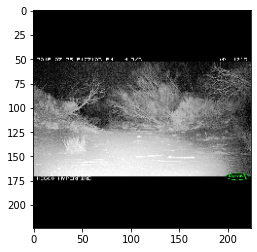

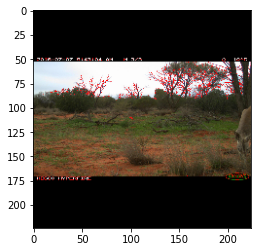

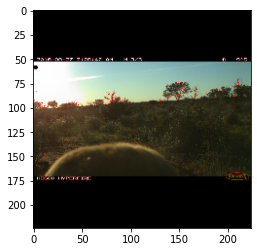

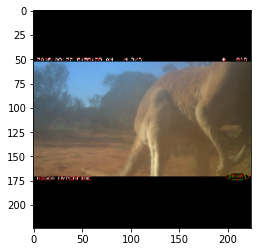

In [7]:
batch_size = 128

num_len_train = int(0.8 * len(training_images))

ttraining_images = training_images[:num_len_train]
ttraining_labels = training_labels[:num_len_train]

valid_images = training_images[num_len_train:]
valid_labels = training_labels[num_len_train:]

training_images = ttraining_images
training_labels = ttraining_labels

# show a few samples
displayImage(cv2.cvtColor(training_images[1], cv2.COLOR_BGR2RGB))
displayImage(cv2.cvtColor(training_images[10], cv2.COLOR_BGR2RGB))
displayImage(cv2.cvtColor(training_images[100], cv2.COLOR_BGR2RGB))
displayImage(cv2.cvtColor(training_images[1000], cv2.COLOR_BGR2RGB))

training_batch_generator = CustomGenerator(training_images, training_labels, batch_size)
validation_batch_generator = CustomGenerator(valid_images, valid_labels, batch_size)

## Train the model

In [8]:
model = tf.keras.models.Sequential([                                    
    tf.keras.layers.Conv2D(96, (7, 7), strides=(2, 2), activation='relu',input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Lambda(lambda x: tf.image.per_image_standardization(x)),
    tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), activation='relu'),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Lambda(lambda x: tf.image.per_image_standardization(x)),
    tf.keras.layers.Conv2D(384, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(384, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096),
    tf.keras.layers.Dense(4096),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])


model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9), \
              loss='categorical_crossentropy', \
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(5)])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', \
    factor=0.1, patience=1, \
    min_lr=0.00001)

model.fit(training_batch_generator,
          validation_data=validation_batch_generator,
          epochs=90,
          callbacks=[reduce_lr])

Epoch 1/90


2022-06-07 07:20:12.980685: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-07 07:20:12.988852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-07 07:20:12.989088: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-07 07:20:12.989698: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

89/89 [==============================] - 19s 179ms/step - loss: 1.1810 - accuracy: 0.6334 - top_k_categorical_accuracy: 0.9757 - val_loss: 0.9684 - val_accuracy: 0.6668 - val_top_k_categorical_accuracy: 0.9884 - lr: 0.0100
Epoch 2/90
89/89 [==============================] - 15s 167ms/step - loss: 0.9402 - accuracy: 0.6702 - top_k_categorical_accuracy: 0.9917 - val_loss: 0.9083 - val_accuracy: 0.6714 - val_top_k_categorical_accuracy: 0.9926 - lr: 0.0100
Epoch 3/90
89/89 [==============================] - 15s 173ms/step - loss: 0.8582 - accuracy: 0.6893 - top_k_categorical_accuracy: 0.9924 - val_loss: 0.9421 - val_accuracy: 0.6482 - val_top_k_categorical_accuracy: 0.9926 - lr: 0.0100
Epoch 4/90
89/89 [==============================] - 15s 167ms/step - loss: 0.8649 - accuracy: 0.6874 - top_k_categorical_accuracy: 0.9935 - val_loss: 0.7744 - val_accuracy: 0.7135 - val_top_k_categorical_accuracy: 0.9930 - lr: 1.0000e-03
Epoch 5/90
89/89 [==============================] - 15s 166ms/step - lo

## Use test set to assess trained model's performance

### Evaluate

In [9]:
print('test_images shape: {}'.format(test_images.shape))
print('test_labels shape: {}'.format(test_labels.shape))

results = model.evaluate(test_images,test_labels)
print('loss: {}'.format(results[0]))
print('accuracy: {}'.format(results[1]))
print('top_k_categorical_accuracy: {}'.format(results[2]))

test_images shape: (3556, 224, 224, 3)
test_labels shape: (3556, 10)


2022-06-07 07:42:00.751150: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 535277568 exceeds 10% of free system memory.
2022-06-07 07:42:00.948104: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 535277568 exceeds 10% of free system memory.


112/112 [==============================] - 2s 15ms/step - loss: 0.5601 - accuracy: 0.8136 - top_k_categorical_accuracy: 0.9955
loss: 0.5601047873497009
accuracy: 0.813554584980011
top_k_categorical_accuracy: 0.9955005645751953


### Predict and print classification report

In [10]:
predictions = (model.predict(test_images) > 0.5).astype("int32")

2022-06-07 07:42:02.973068: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 535277568 exceeds 10% of free system memory.
2022-06-07 07:42:03.165387: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 535277568 exceeds 10% of free system memory.


112/112 [==============================] - 2s 13ms/step


In [11]:
print("test_classes: {}".format(test_classes))
print("train classes count: {}".format(counter_test))
# classification_report uses alphabetic ordering of the classes, so to match the encoded labels to the target_names, provide a sortest list of classes
# https://stackoverflow.com/a/48495303
sorted_test_classes = sorted(test_classes)
print(classification_report(test_labels, predictions, target_names=sorted_test_classes))

test_classes: ['Empty photo', 'Kangaroo', 'Emu', 'Human Presense/Deployment', 'Other', 'Fox', 'Cat', 'Bird', 'Rabbit', 'Dog']
train classes count: Counter({'Kangaroo': 2329, 'Empty photo': 650, 'Emu': 247, 'Human Presense/Deployment': 209, 'Fox': 66, 'Cat': 31, 'Rabbit': 12, 'Bird': 7, 'Other': 4, 'Dog': 1})
                           precision    recall  f1-score   support

                     Bird       0.00      0.00      0.00         7
                      Cat       0.00      0.00      0.00        31
                      Dog       0.00      0.00      0.00         1
              Empty photo       0.83      0.52      0.64       650
                      Emu       0.79      0.45      0.57       247
                      Fox       0.00      0.00      0.00        66
Human Presense/Deployment       0.80      0.34      0.48       209
                 Kangaroo       0.87      0.94      0.90      2329
                    Other       0.00      0.00      0.00         4
                   

/home/luke/miniconda3/envs/cv-project-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luke/miniconda3/envs/cv-project-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Confusion matrix

In [12]:
matrix = confusion_matrix(test_labels.argmax(axis=1), predictions.argmax(axis=1))
print(matrix)

[[   5    0    0    0    0    0    0    2    0    0]
 [  13    0    0    8    0    1    2    7    0    0]
 [   0    0    0    0    1    0    0    0    0    0]
 [ 108    0    0  340    5    0    5  192    0    0]
 [  97    0    0    7  111    0    2   30    0    0]
 [  22    0    0    4    1    0    0   39    0    0]
 [  59    0    0    4   20    0   72   54    0    0]
 [  84    0    0   44    2    0    9 2190    0    0]
 [   1    0    0    0    0    0    0    3    0    0]
 [   5    0    0    2    0    0    0    5    0    0]]


### Accuracy

In [13]:
acc = accuracy_score(test_labels, predictions)
print(acc)

0.7629358830146231


## Use a distinct dataset to assess trained model's performance
* still camera trap images from same location(s), but subset was not used for training, validation, or testing
* note: images are not pre-processed, and are simply loaded in and resized
* TODO: use Australian camera trap images from different location(s) to assess performance

folders_dataset: ['BB01', 'BB03', 'BB04', 'BB05', 'BB06', 'BB07', 'BB08', 'BB09', 'BB10', 'BB11']
reading in images for subset: BB01
all_image_filenames length: 106
reading in images for subset: BB03
all_image_filenames length: 69
reading in images for subset: BB04
all_image_filenames length: 1694
reading in images for subset: BB05
all_image_filenames length: 128
reading in images for subset: BB06
all_image_filenames length: 540
reading in images for subset: BB07
all_image_filenames length: 61
reading in images for subset: BB08
all_image_filenames length: 52
reading in images for subset: BB09
all_image_filenames length: 131
reading in images for subset: BB10
all_image_filenames length: 300
reading in images for subset: BB11
all_image_filenames length: 159


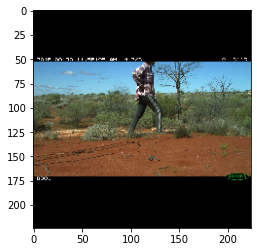

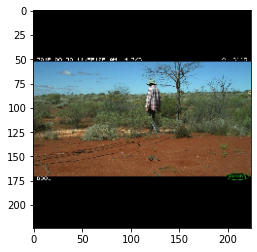

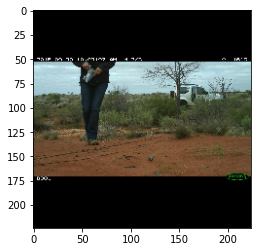

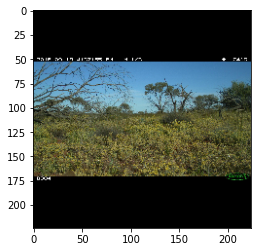

In [14]:
unlabelled_test_images = []
folders_dataset = next(os.walk('data/unlabelled_test_data/20160929_September'))[1]
folders_dataset = sorted(folders_dataset)
print('folders_dataset: {}'.format(folders_dataset))
for folder in folders_dataset:
    unlabelled_test_images = [*unlabelled_test_images, *readInImages('unlabelled_test_data/20160929_September', folder, False)]

displayImage(cv2.cvtColor(unlabelled_test_images[1], cv2.COLOR_BGR2RGB))
displayImage(cv2.cvtColor(unlabelled_test_images[10], cv2.COLOR_BGR2RGB))
displayImage(cv2.cvtColor(unlabelled_test_images[100], cv2.COLOR_BGR2RGB))
displayImage(cv2.cvtColor(unlabelled_test_images[1000], cv2.COLOR_BGR2RGB))

unlabelled_test_images = np.stack(unlabelled_test_images, axis = 0)

### Predict
* TODO: resolve encoded classes to their labels

In [15]:
y_pred = (model.predict(unlabelled_test_images) > 0.5).astype("int32")
y_classes = y_pred.argmax(axis=-1)
print('y_classes: {}'.format(y_classes))

  1/102 [..............................] - ETA: 2s

2022-06-07 07:42:53.288634: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 487710720 exceeds 10% of free system memory.


102/102 [==============================] - 1s 14ms/step
y_classes: [6 6 6 ... 7 7 6]


## Save the model
* use the current date/time so we can keep incrementation progress of the model as we re-run it

In [16]:
if model_name == None:
    now = datetime.now()
    dt_string = now.strftime('%d-%m-%Y_%H:%M:%S')
    print("saving model as: 'ZFNet-{}.h5'.'".format(dt_string))

    model.save('saved_models/ZFNet-{}.h5'.format(dt_string))
else:
    existing_models = next(os.walk('saved_models/final'))[2]
    print('existing_models: {}'.format(existing_models))
    if model_name in existing_models:
        raise Exception('Tried to save a model that already exists. Aborting.')
    else:
        print("saving model as: '{}.h5'.'".format(model_name))
        model.save('saved_models/final/{}.h5'.format(model_name))

existing_models: ['InceptionV3-baseline-2.h5', 'InceptionV3-baseline-1.h5', 'ZFNet-pre-processing-hist-eq-dark-and-canny-non-empty-1.h5', 'ZFNet-pre-processing-hist-eq-dark-and-canny-non-empty-2.h5', 'ZFNet-baseline-3.h5', 'InceptionV3-baseline-3.h5', 'ZFNet-baseline-2.h5', 'ZFNet-baseline-1.h5']
saving model as: 'ZFNet-pre-processing-hist-eq-dark-and-canny-non-empty-3.h5'.'


## Free up the GPU's memory

In [17]:
cuda.select_device(0)
cuda.close()